In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Check GPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB\n")
else:
    print("⚠️  WARNING: No GPU detected! Training will be SLOW.")
    print("   Go to Runtime > Change runtime type > GPU\n")

🖥️  Device: cuda
   GPU: Tesla T4
   Memory: 15.8 GB



In [3]:
# ============================================================================
# COMPLETE IMPORTS - RUN THIS CELL FIRST
# ============================================================================

# Install packages (only needed once)
!pip install -q transformers torch pandas scikit-learn matplotlib seaborn tqdm

# Import everything
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW  # ← Import from torch.optim, not transformers
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
import os

print("✅ All packages imported successfully!\n")

# Test that BERT is available
print("Testing imports...")
print(f"  ✓ PyTorch: {torch.__version__}")
print(f"  ✓ CUDA available: {torch.cuda.is_available()}")
print(f"  ✓ BertForSequenceClassification: Available")
print(f"  ✓ AdamW: Available")
print("\n🚀 Ready to proceed!\n")

✅ All packages imported successfully!

Testing imports...
  ✓ PyTorch: 2.9.0+cu126
  ✓ CUDA available: True
  ✓ BertForSequenceClassification: Available
  ✓ AdamW: Available

🚀 Ready to proceed!



In [4]:
# ============================================================================
# LOAD DATA
# ============================================================================
print("📂 Loading preprocessed data...")

DATA_DIR = '/content/drive/MyDrive/EAI6010_Final Project/Processed_Data'
MODELS_DIR = '/content/drive/MyDrive/EAI6010_Final Project/Models'
RESULTS_DIR = '/content/drive/MyDrive/EAI6010_Final Project/Results/BERT'

import os
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

train_df = pd.read_csv(f'{DATA_DIR}/train_processed.csv')
val_df = pd.read_csv(f'{DATA_DIR}/val_processed.csv')
test_df = pd.read_csv(f'{DATA_DIR}/test_processed.csv')

print(f"✅ Train: {len(train_df):,} samples")
print(f"✅ Val: {len(val_df):,} samples")
print(f"✅ Test: {len(test_df):,} samples\n")

📂 Loading preprocessed data...
✅ Train: 45,414 samples
✅ Val: 9,090 samples
✅ Test: 9,069 samples



In [5]:
# ============================================================================
# DATASET CLASS
# ============================================================================
class FakedditDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [6]:
# ============================================================================
# PREPARE DATA
# ============================================================================
print("🔧 Preparing BERT tokenizer and datasets...")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets - REDUCED SIZE for faster training
TRAIN_SIZE = 20000  # Use 20K instead of full 45K for speed
VAL_SIZE = 5000

train_dataset = FakedditDataset(
    train_df['clean_title'].values[:TRAIN_SIZE],
    train_df['2_way_label'].values[:TRAIN_SIZE],
    tokenizer
)

val_dataset = FakedditDataset(
    val_df['clean_title'].values[:VAL_SIZE],
    val_df['2_way_label'].values[:VAL_SIZE],
    tokenizer
)

test_dataset = FakedditDataset(
    test_df['clean_title'].values,
    test_df['2_way_label'].values,
    tokenizer
)

# Create dataloaders
BATCH_SIZE = 32  # Adjust if GPU memory issues

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Train batches: {len(train_loader)}")
print(f"✅ Val batches: {len(val_loader)}")
print(f"✅ Test batches: {len(test_loader)}\n")

🔧 Preparing BERT tokenizer and datasets...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

✅ Train batches: 625
✅ Val batches: 157
✅ Test batches: 284



In [7]:
# ============================================================================
# MODEL SETUP
# ============================================================================
print("🤖 Loading BERT model...")

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

model = model.to(device)
print("✅ Model loaded and moved to GPU\n")

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Scheduler
EPOCHS = 2  # Quick training: 2 epochs instead of 3
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"⚙️  Training configuration:")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: 2e-5")
print(f"   Total steps: {total_steps}\n")

🤖 Loading BERT model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded and moved to GPU

⚙️  Training configuration:
   Epochs: 2
   Batch size: 32
   Learning rate: 2e-5
   Total steps: 1250



In [8]:
# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []
    correct = 0
    total = 0

    progress_bar = tqdm(data_loader, desc='Training')

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())

        progress_bar.set_postfix({
            'loss': np.mean(losses[-10:]),
            'acc': correct / total
        })

    return np.mean(losses), correct / total

def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)

            losses.append(loss.item())
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='binary'
    )

    return {
        'loss': np.mean(losses),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions,
        'labels': true_labels
    }

In [9]:
# ============================================================================
# TRAINING LOOP
# ============================================================================
print("="*70)
print("🚀 STARTING BERT TRAINING")
print("="*70 + "\n")

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

best_val_f1 = 0
start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\n{'='*70}")
    print(f"📊 Epoch {epoch + 1}/{EPOCHS}")
    print('='*70)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f"\n  Train Loss: {train_loss:.4f}")
    print(f"  Train Acc: {train_acc:.4f}")

    # Validate
    val_metrics = eval_model(model, val_loader, device)
    print(f"\n  Val Loss: {val_metrics['loss']:.4f}")
    print(f"  Val Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"  Val Precision: {val_metrics['precision']:.4f}")
    print(f"  Val Recall: {val_metrics['recall']:.4f}")
    print(f"  Val F1: {val_metrics['f1']:.4f}")

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_metrics['loss'])
    history['val_acc'].append(val_metrics['accuracy'])
    history['val_f1'].append(val_metrics['f1'])

    # Save best model
    if val_metrics['f1'] > best_val_f1:
        best_val_f1 = val_metrics['f1']
        torch.save(model.state_dict(), f'{MODELS_DIR}/bert_best_model.pt')
        print(f"\n  💾 Saved best model (F1: {best_val_f1:.4f})")

training_time = time.time() - start_time

print("\n" + "="*70)
print("✅ TRAINING COMPLETE!")
print("="*70)
print(f"\n🏆 Best Validation F1: {best_val_f1:.4f}")
print(f"⏱️  Total Training Time: {training_time/60:.1f} minutes\n")

🚀 STARTING BERT TRAINING


📊 Epoch 1/2


Training:   0%|          | 0/625 [00:00<?, ?it/s]


  Train Loss: 0.4299
  Train Acc: 0.8050


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]


  Val Loss: 0.3703
  Val Accuracy: 0.8350
  Val Precision: 0.8149
  Val Recall: 0.8025
  Val F1: 0.8086

  💾 Saved best model (F1: 0.8086)

📊 Epoch 2/2


Training:   0%|          | 0/625 [00:00<?, ?it/s]


  Train Loss: 0.2889
  Train Acc: 0.8844


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]


  Val Loss: 0.3767
  Val Accuracy: 0.8434
  Val Precision: 0.8091
  Val Recall: 0.8370
  Val F1: 0.8228

  💾 Saved best model (F1: 0.8228)

✅ TRAINING COMPLETE!

🏆 Best Validation F1: 0.8228
⏱️  Total Training Time: 14.8 minutes



In [10]:
# ============================================================================
# TEST EVALUATION
# ============================================================================
print("="*70)
print("🔍 FINAL TEST EVALUATION")
print("="*70 + "\n")

# Load best model
model.load_state_dict(torch.load(f'{MODELS_DIR}/bert_best_model.pt'))

test_metrics = eval_model(model, test_loader, device)

print(f"📊 Test Results:")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F1-Score:  {test_metrics['f1']:.4f}\n")

🔍 FINAL TEST EVALUATION



Evaluating:   0%|          | 0/284 [00:00<?, ?it/s]

📊 Test Results:
  Accuracy:  0.8447 (84.47%)
  Precision: 0.8142
  Recall:    0.8332
  F1-Score:  0.8236



In [11]:
# ============================================================================
# COMPARISON WITH BASELINE
# ============================================================================
print("="*70)
print("📊 BASELINE vs BERT COMPARISON")
print("="*70 + "\n")

baseline_acc = 0.757  # Your Linear SVM result
baseline_f1 = 0.714

bert_acc = test_metrics['accuracy']
bert_f1 = test_metrics['f1']

improvement_acc = ((bert_acc - baseline_acc) / baseline_acc) * 100
improvement_f1 = ((bert_f1 - baseline_f1) / baseline_f1) * 100

print(f"{'Metric':<15} {'Baseline':<12} {'BERT':<12} {'Improvement'}")
print("-" * 55)
print(f"{'Accuracy':<15} {baseline_acc:.4f}      {bert_acc:.4f}      +{improvement_acc:.1f}%")
print(f"{'F1-Score':<15} {baseline_f1:.4f}      {bert_f1:.4f}      +{improvement_f1:.1f}%")
print()

📊 BASELINE vs BERT COMPARISON

Metric          Baseline     BERT         Improvement
-------------------------------------------------------
Accuracy        0.7570      0.8447      +11.6%
F1-Score        0.7140      0.8236      +15.3%



📊 Creating visualizations...



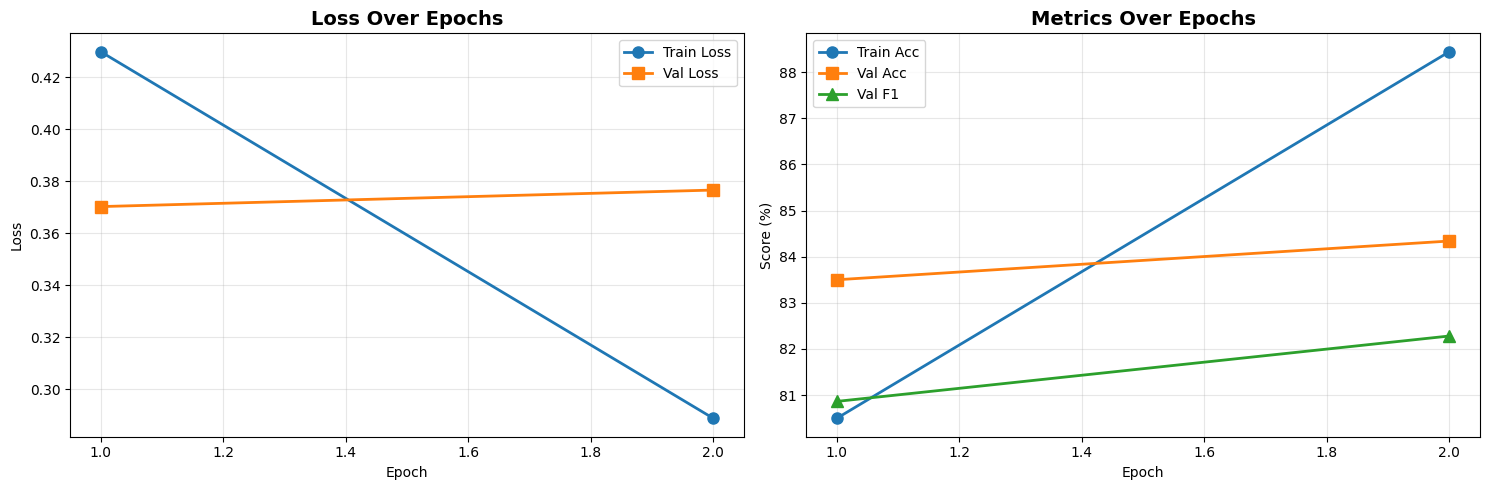

✅ Saved: training_history.png



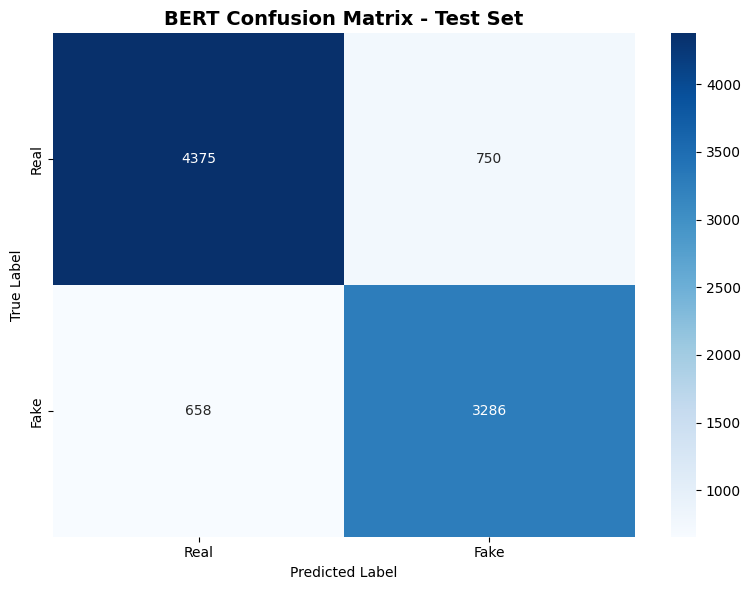

✅ Saved: confusion_matrix.png



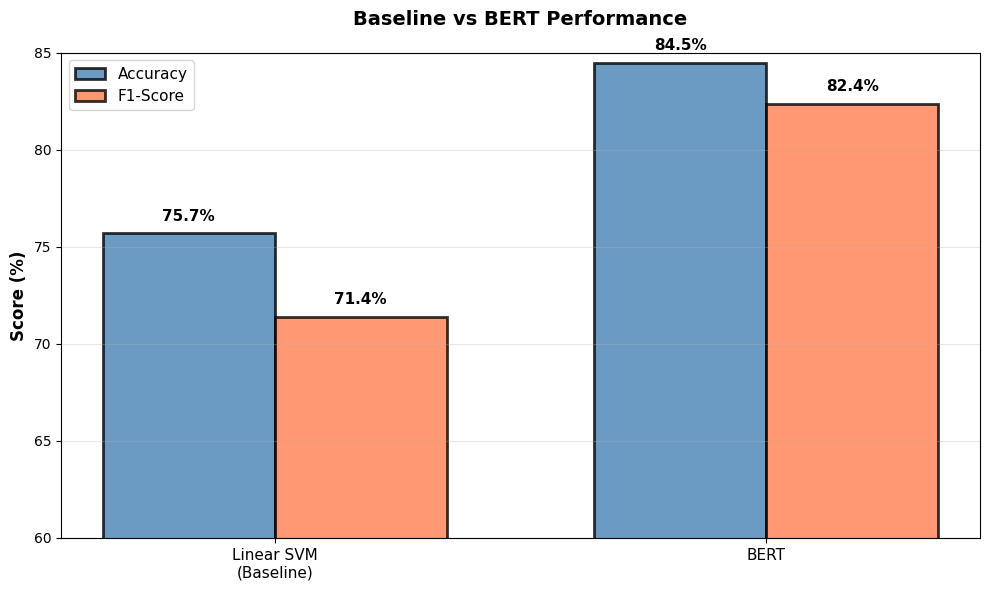

✅ Saved: baseline_vs_bert.png



In [12]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("📊 Creating visualizations...\n")

# 1. Training History
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, EPOCHS + 1)

axes[0].plot(epochs_range, history['train_loss'], 'o-', label='Train Loss', linewidth=2, markersize=8)
axes[0].plot(epochs_range, history['val_loss'], 's-', label='Val Loss', linewidth=2, markersize=8)
axes[0].set_title('Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_range, [x*100 for x in history['train_acc']], 'o-', label='Train Acc', linewidth=2, markersize=8)
axes[1].plot(epochs_range, [x*100 for x in history['val_acc']], 's-', label='Val Acc', linewidth=2, markersize=8)
axes[1].plot(epochs_range, [x*100 for x in history['val_f1']], '^-', label='Val F1', linewidth=2, markersize=8)
axes[1].set_title('Metrics Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: training_history.png\n")

# 2. Confusion Matrix
cm = confusion_matrix(test_metrics['labels'], test_metrics['predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title('BERT Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: confusion_matrix.png\n")

# 3. Comparison Chart
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Linear SVM\n(Baseline)', 'BERT']
accuracy_scores = [baseline_acc * 100, bert_acc * 100]
f1_scores = [baseline_f1 * 100, bert_f1 * 100]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy',
               color='steelblue', alpha=0.8, edgecolor='black', linewidth=2)
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1-Score',
               color='coral', alpha=0.8, edgecolor='black', linewidth=2)

ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax.set_title('Baseline vs BERT Performance', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(60, 85)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom',
                fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/baseline_vs_bert.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: baseline_vs_bert.png\n")

In [13]:
# ============================================================================
# SAVE RESULTS
# ============================================================================
results_summary = {
    'Model': ['Linear SVM (Baseline)', 'BERT'],
    'Accuracy': [baseline_acc, bert_acc],
    'Precision': [0.728, test_metrics['precision']],
    'Recall': [0.700, test_metrics['recall']],
    'F1-Score': [baseline_f1, bert_f1],
    'Training Time': ['0.2s', f'{training_time:.0f}s']
}

results_df = pd.DataFrame(results_summary)
results_df.to_csv(f'{RESULTS_DIR}/final_comparison.csv', index=False)

print(f"\n📁 Saved files:")
print(f"   • Model: {MODELS_DIR}/bert_best_model.pt")
print(f"   • Results: {RESULTS_DIR}/final_comparison.csv")
print(f"   • Plots: {RESULTS_DIR}/*.png")
print("="*70)


📁 Saved files:
   • Model: /content/drive/MyDrive/EAI6010_Final Project/Models/bert_best_model.pt
   • Results: /content/drive/MyDrive/EAI6010_Final Project/Results/BERT/final_comparison.csv
   • Plots: /content/drive/MyDrive/EAI6010_Final Project/Results/BERT/*.png
